## Notebook to preprocess all external data for each SA2 region
* Make sure to run datascrape.ipynb before running

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import sys
import os
sys.path.append(os.path.abspath(".."))
from scripts.preproccessing import extend_data, extend_inflation
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import random 
from statsmodels.tsa.stattools import adfuller

POPULATION DATA PROCESSING:

In [2]:
## Population Data
## Population Projection Data:\n",
population_projection = pd.read_csv("../data/landing/yearly_pop_projection_perSA.csv")

In [3]:
# Filter for 'Persons' so we only get the total population for each region\,
df_persons = population_projection[population_projection['SEX'] == 'Persons']

# Pivot the DataFrame to get `SA2_NAME` as rows, `YEAR` as columns, and `Total` as values\n
df_pivot = df_persons.pivot_table(index='SA2_NAME', columns='YEAR', values='Total', aggfunc='sum')


In [4]:
# Read the GeoPackage
population_gdf = gpd.read_file("../data/population/population_extracted/32180_ERP_2023_SA2_GDA2020.gpkg")


In [5]:
# extract SA2 name and ERP (estimated residential population) for victoria only

population_gdf = population_gdf[population_gdf['State_name_2021'] == 'Victoria']

population_gdf = population_gdf[[ 'SA2_name_2021',
 'ERP_2006',
 'ERP_2007',
 'ERP_2008',
 'ERP_2009',
 'ERP_2010',
 'ERP_2011',
 'ERP_2012',
 'ERP_2013',
 'ERP_2014',
 'ERP_2015',
 'ERP_2016',
 'ERP_2017',
 'ERP_2018',
 'ERP_2019',
 'ERP_2020',
 'ERP_2021',
 'ERP_2022',
 'ERP_2023']]

In [24]:
population_df = pd.DataFrame(population_gdf).set_index('SA2_name_2021')
population_df.columns = [2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023]

In [25]:
population_df = population_df.join(df_pivot.loc[:, 2024:2029], how='inner')
population_df.head()

,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,...,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029
Alfredton,6761.0,7034.0,7272.0,7614.0,7894.0,8452.0,9060.0,9714.0,10338.0,11039.0,...,15507,16841,18002,18997,16896,17489,18056,18611,19166,19716
Ballarat,12356.0,12408.0,12480.0,12476.0,12462.0,12365.0,12357.0,12352.0,12327.0,12300.0,...,12196,12071,11938,11809,12302,12296,12279,12252,12223,12189
Buninyong,6037.0,6131.0,6252.0,6431.0,6595.0,6725.0,6854.0,6984.0,7082.0,7191.0,...,7377,7229,7247,7323,8520,8652,8778,8900,9021,9139
Delacombe,5041.0,5206.0,5349.0,5557.0,5699.0,5838.0,6020.0,6267.0,6583.0,6846.0,...,9755,10648,11798,12869,9142,9358,9564,9763,9961,10155
Smythes Creek,3542.0,3594.0,3658.0,3714.0,3774.0,3819.0,3872.0,3914.0,3945.0,3966.0,...,4152,4211,4223,4268,4197,4222,4244,4263,4285,4305


HOMELESSNESS DATA:

In [2]:
# Reading in the files  for the seperate years

homelessness_df_21 = pd.read_excel('../data/homelessness/homelessness21.xlsx', sheet_name='Table_5.3')
homelessness_df_11 = pd.read_excel('../data/homelessness/homelessness11.xlsx', sheet_name='Table_1')
homelessness_df_16 = pd.read_excel('../data/homelessness/homelessness16.xlsx', sheet_name='Table_5.3')

In [3]:
# Processing the data for 2021

homelessness_df_21 = homelessness_df_21.loc[775:1375]
homelessness_df_21 = homelessness_df_21[pd.notna(homelessness_df_21['Unnamed: 3'])]
homelessness_df_21 = homelessness_df_21.iloc[:, -2:]
homelessness_df_21.columns = ['SA2_name_2021', 'all_homeless_persons_2021']

In [4]:
# Processing the data for 2016

homelessness_df_16 = homelessness_df_16.loc[707:1249]
homelessness_df_16 = homelessness_df_16[pd.notna(homelessness_df_16['Unnamed: 3'])]
homelessness_df_16 = homelessness_df_16.iloc[:, -2:]
homelessness_df_16.columns = ['SA2_name_2021', 'all_homeless_persons_2016']

In [5]:
# Processing the data for 2011

homelessness_df_11 = homelessness_df_11.loc[668:1180]
homelessness_df_11 = homelessness_df_11[pd.notna(homelessness_df_11['Unnamed: 3'])]
homelessness_df_11 = homelessness_df_11.iloc[:, -2:]
homelessness_df_11.columns = ['SA2_name_2021', 'all_homeless_persons_2011']

In [6]:
# Merging the data for the different years

homelessness_df = homelessness_df_11.merge(homelessness_df_16, on='SA2_name_2021').merge(homelessness_df_21, on='SA2_name_2021')
homelessness_df = homelessness_df.set_index('SA2_name_2021')
homelessness_df.columns = [2011,2016,2021]
homelessness_df.head()

,2011,2016,2021
SA2_name_2021,,,
Buninyong,3,0,43
Delacombe,33,38,43
Smythes Creek,0,0,5
Wendouree - Miners Rest,51,74,93
Creswick - Clunes,17,4,15



Rows with NaN values: []


/Users/lauragrant/Documents/GitHub/project-2-group-real-estate-industry-project-31/scripts/preproccessing.py:222: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(df.mean(), inplace=True)


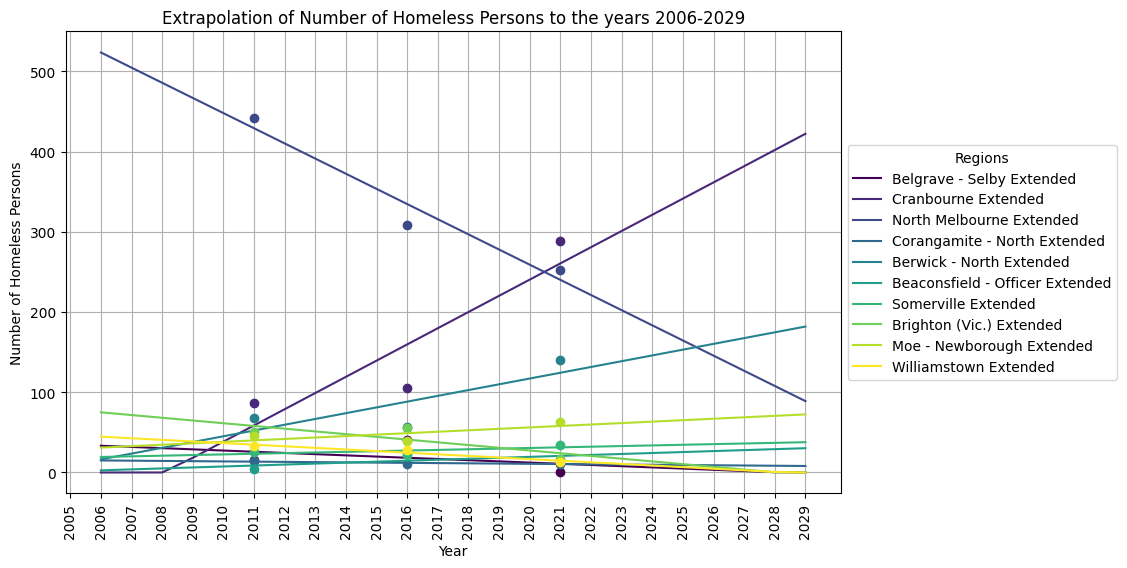

In [7]:
# Run the function to extrapaloate, interpolate and graph our data
extended_homelessness_df = extend_data(homelessness_df, 'Number of Homeless Persons')

SOCIO ECONOMIC DATA: 

In [9]:
# Read in the socioeconomic files

socioeconomic_df_21 = pd.read_excel('../data/socioeconomic/socioeconomic21.xlsx', sheet_name='Table 1')
socioeconomic_df_16 = pd.read_excel('../data/socioeconomic/socioeconomic16.xlsx', sheet_name='Table 1')
socioeconomic_df_11 = pd.read_excel('../data/socioeconomic/socioeconomic11.xlsx', sheet_name='Table 2')


In [10]:
# Processing the data for 2021

socioeconomic_df_21 = socioeconomic_df_21.loc[634:1149]
socioeconomic_df_21 = socioeconomic_df_21.iloc[:, [1, 4]]
socioeconomic_df_21.columns = ['SA2_name_2021', 'Index of Relative Socio-economic Advantage and Disadvantage 2021']

In [11]:
# Processing the data for 2016

socioeconomic_df_16 = socioeconomic_df_16.loc[565:1019]
socioeconomic_df_16 = socioeconomic_df_16.iloc[:, [1, 4]]
socioeconomic_df_16.columns = ['SA2_name_2021', 'Index of Relative Socio-economic Advantage and Disadvantage 2016']

In [12]:
# Processing the data for 2011

socioeconomic_df_11 = socioeconomic_df_11.loc[1459:1882]
socioeconomic_df_11 = socioeconomic_df_11.iloc[:, [1, 3]]
socioeconomic_df_11.columns = ['SA2_name_2021', 'Index of Relative Socio-economic Advantage and Disadvantage 2011']

In [13]:
# Mergind the data

socioeconomic_df = socioeconomic_df_11.merge(socioeconomic_df_16, on='SA2_name_2021').merge(socioeconomic_df_21, on='SA2_name_2021')

In [14]:
# Formatting the data for extrapolation

socioeconomic_df.rename(columns={
    'Index of Relative Socio-economic Advantage and Disadvantage 2011': 2011,
    'Index of Relative Socio-economic Advantage and Disadvantage 2016': 2016,
    'Index of Relative Socio-economic Advantage and Disadvantage 2021': 2021
}, inplace=True)
socioeconomic_df.set_index('SA2_name_2021', inplace=True)


Rows with NaN values: []


/Users/lauragrant/Documents/GitHub/project-2-group-real-estate-industry-project-31/scripts/preproccessing.py:222: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(df.mean(), inplace=True)


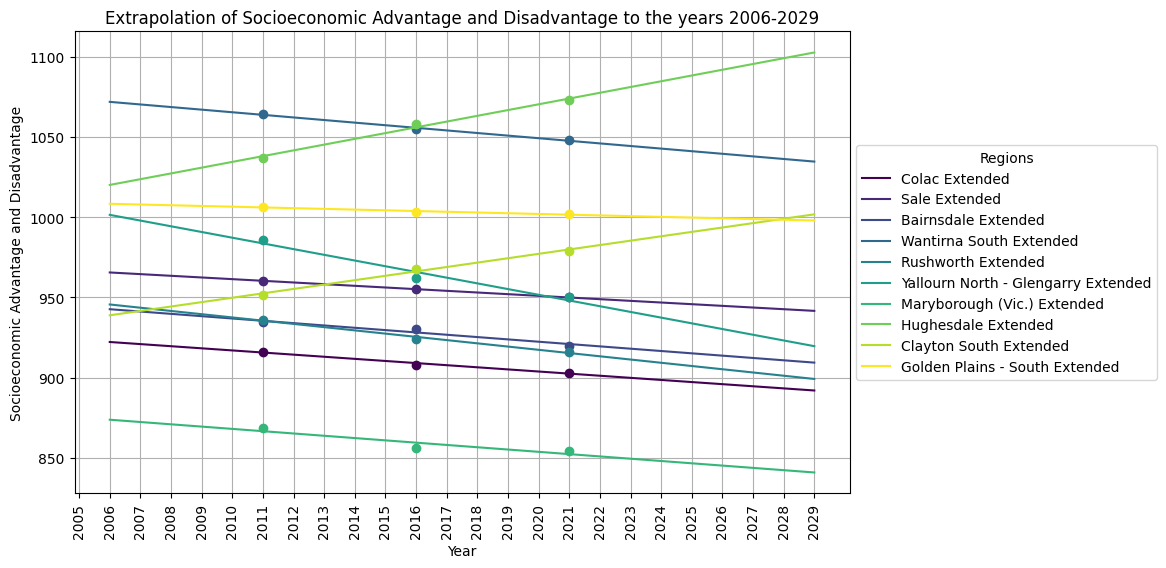

In [15]:
# Run the function to extrapaloate, interpolate and graph our data
extended_socioeconomic_df = extend_data(socioeconomic_df, 'Socioeconomic Advantage and Disadvantage')

INFLATION PROCESSING:

During this seciton we must:
a. extract housing CPI index
b. extract the overall CPI with housing removed
as a measure of all other inflation this will be best for analysis to keep both variables as independent as possible

In [17]:
# Read in our different sorts of data
housing_cpi_df = pd.read_excel('../data/inflation/inflation.xlsx', sheet_name='Data1')
excluding_housing_cpi_df = pd.read_excel('../data/inflation/inflation.xlsx', sheet_name='Data2')

# Take only the columns we want
housing_cpi_df = housing_cpi_df[['Unnamed: 0','Index Numbers ;  Housing ;  Melbourne ;']]
excluding_housing_cpi_df = excluding_housing_cpi_df[['Unnamed: 0','Index Numbers ;  All groups CPI excluding Housing ;  Melbourne ;']]
housing_cpi_df = housing_cpi_df.rename(columns={'Unnamed: 0': "quarter"})

# Join the datasets and make the data yearly instead of quarterly
inflation_df = pd.concat([housing_cpi_df,excluding_housing_cpi_df],axis=1).drop('Unnamed: 0', axis=1).dropna().iloc[9:].rename(columns={'Index Numbers ;  Housing ;  Melbourne ;': "housing_index", 'Index Numbers ;  All groups CPI excluding Housing ;  Melbourne ;': 'CPI_without_housing'})
inflation_df['Year'] = pd.to_datetime(inflation_df['quarter']).dt.year
yearly_avg = inflation_df.groupby('Year')[['housing_index', 'CPI_without_housing']].mean()

# Transpose the DataFrame so that 'Year' becomes the columns, and we have rows for housing_index and CPI_without_housing
new_inflation_df = yearly_avg.T.loc[:, 2006:2024]


Rows with NaN values: []


/Users/lauragrant/Documents/GitHub/project-2-group-real-estate-industry-project-31/scripts/preproccessing.py:364: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(df.mean(), inplace=True)


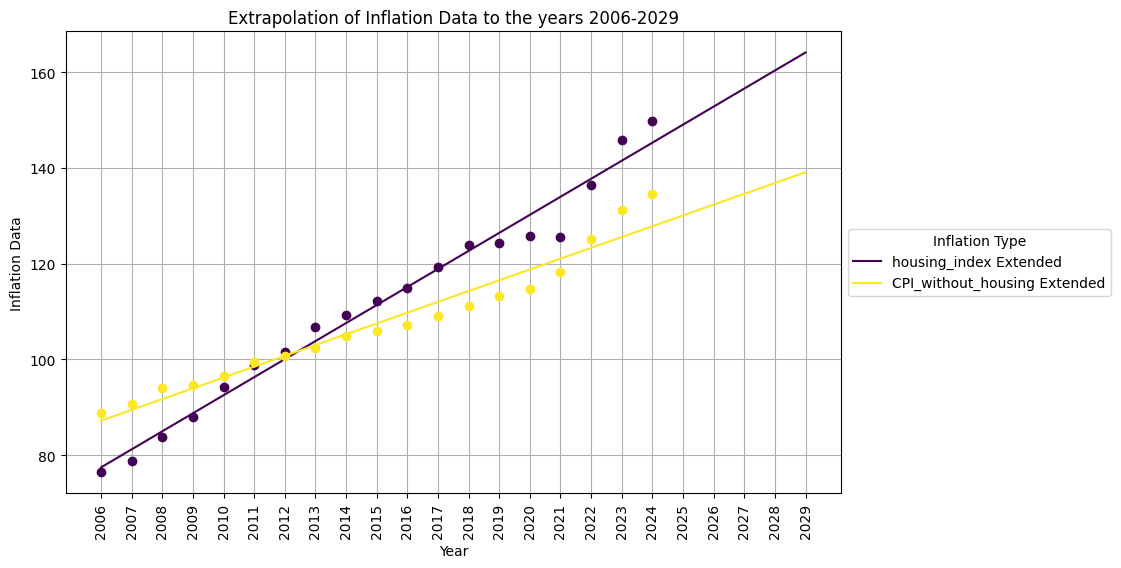

In [18]:
# Run the function to extrapaloate, interpolate and graph our data
extended_inflation_df = extend_inflation(new_inflation_df, 'Inflation Data')

In [66]:
# lets look at population distributions

In [67]:
pop_dist_df = pd.read_excel('../data/population_dist/population_dist.xlsx', sheet_name='Table 1')

In [68]:
pop_dist_df = pop_dist_df.loc[9879:14576]
pop_dist_df = pop_dist_df.iloc[:, [1, 2, 4, 9, 127, 131, 142, 156]]
pop_dist_df.columns = ['SA2_name_2021', 'Year', 'Population Density', 'Median Age', 'Overseas Arrivals', 'Percentage Aboriginal and Torres Straight Islander', 'Percentage Overseas Born', 'Percentage Australian Citizen']
# population density in persons/km^2

In [69]:
population_density_df = pop_dist_df.pivot(index='SA2_name_2021', columns='Year', values='Population Density')
median_age_df = pop_dist_df.pivot(index='SA2_name_2021', columns='Year', values='Median Age')
overseas_arrivals_df = pop_dist_df.pivot(index='SA2_name_2021', columns='Year', values='Overseas Arrivals')
percentage_aboriginal_torres_straight_df = pop_dist_df.pivot(index='SA2_name_2021', columns='Year', values='Percentage Aboriginal and Torres Straight Islander')
percentage_overseas_born_df = pop_dist_df.pivot(index='SA2_name_2021', columns='Year', values='Percentage Overseas Born')
percentage_australian_citizen_df = pop_dist_df.pivot(index='SA2_name_2021', columns='Year', values='Percentage Australian Citizen')

/Users/charlieamad/Documents/GitHub/project-2-group-real-estate-industry-project-31/scripts/preproccessing.py:210: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace('-', np.nan, inplace=True) # replace '-' values with NaN
/Users/charlieamad/Documents/GitHub/project-2-group-real-estate-industry-project-31/scripts/preproccessing.py:222: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna(df.mean(), inplace=True)



Rows with NaN values: ['Alps - East', 'Alps - West', 'Lake King', 'Royal Botanic Gardens Victoria', 'West Melbourne - Industrial', 'Wilsons Promontory']


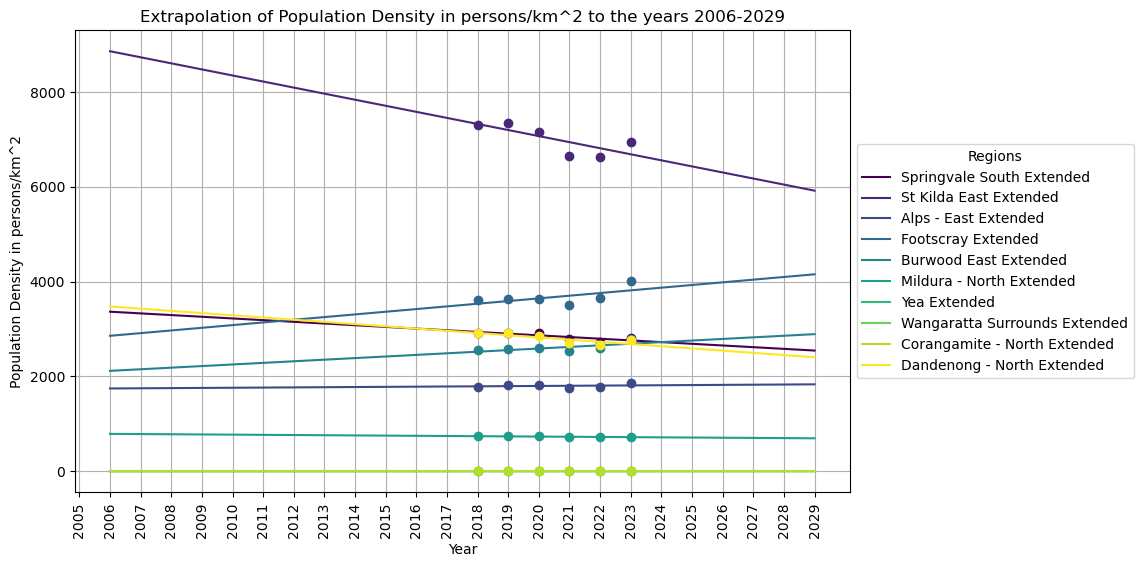

/Users/charlieamad/Documents/GitHub/project-2-group-real-estate-industry-project-31/scripts/preproccessing.py:210: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace('-', np.nan, inplace=True) # replace '-' values with NaN
/Users/charlieamad/Documents/GitHub/project-2-group-real-estate-industry-project-31/scripts/preproccessing.py:222: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna(df.mean(), inplace=True)



Rows with NaN values: ['Alps - East', 'Lake King', 'Royal Botanic Gardens Victoria', 'West Melbourne - Industrial']


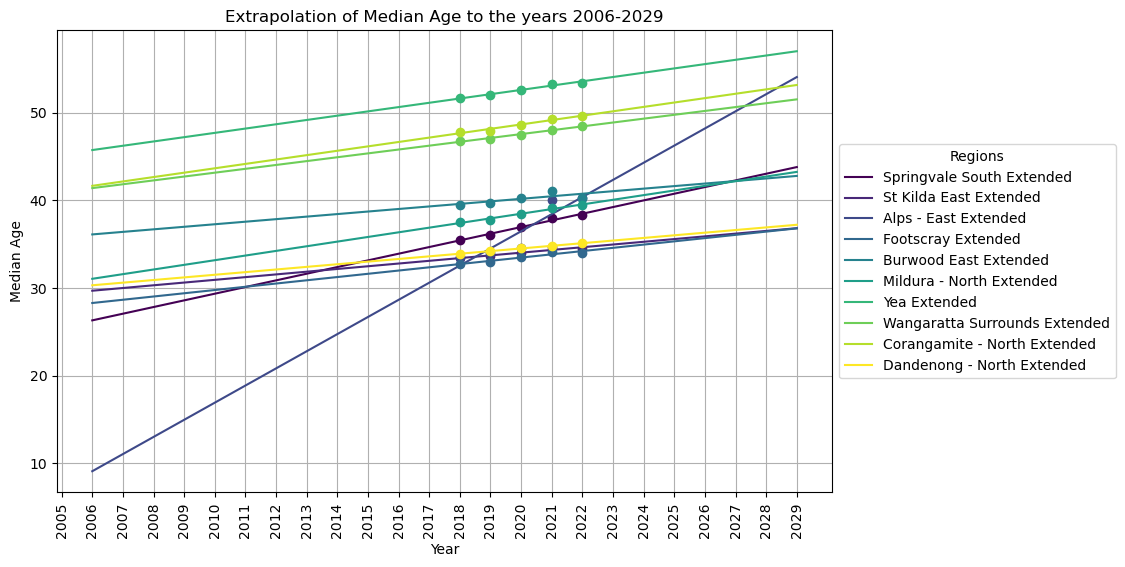

/Users/charlieamad/Documents/GitHub/project-2-group-real-estate-industry-project-31/scripts/preproccessing.py:210: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace('-', np.nan, inplace=True) # replace '-' values with NaN
/Users/charlieamad/Documents/GitHub/project-2-group-real-estate-industry-project-31/scripts/preproccessing.py:222: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna(df.mean(), inplace=True)



Rows with NaN values: ['Alps - East', 'Alps - West', 'Braeside', 'Essendon Airport', 'Flemington Racecourse', 'French Island', 'Kerang', 'Lake King', 'Melbourne Airport', 'Moorabbin Airport', 'Royal Botanic Gardens Victoria', 'Upper Yarra Valley', 'West Melbourne - Industrial', 'Wilsons Promontory']


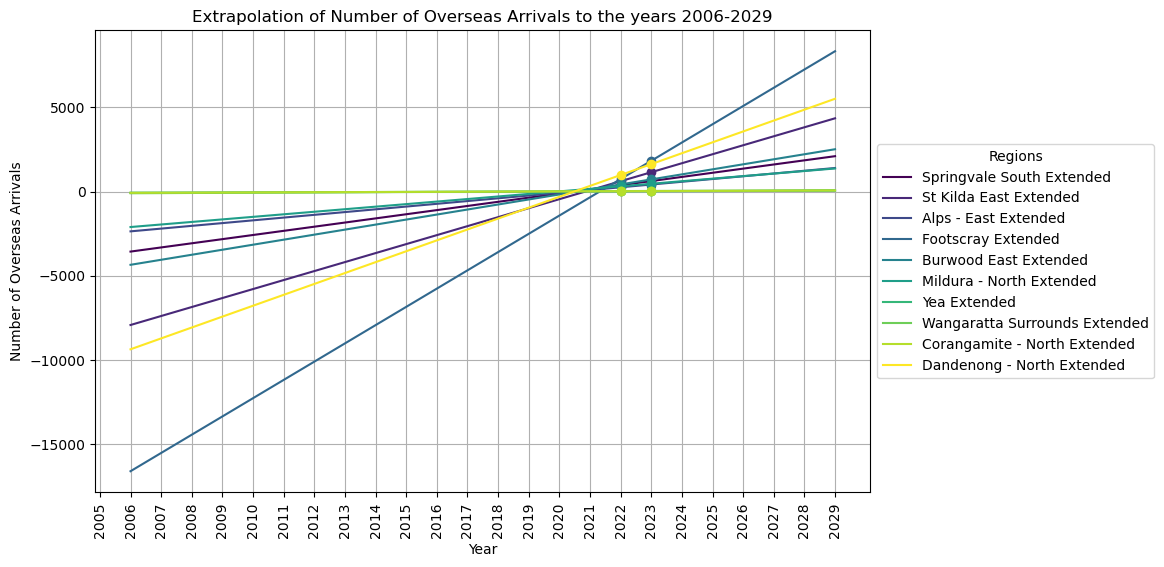

/Users/charlieamad/Documents/GitHub/project-2-group-real-estate-industry-project-31/scripts/preproccessing.py:210: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace('-', np.nan, inplace=True) # replace '-' values with NaN
/Users/charlieamad/Documents/GitHub/project-2-group-real-estate-industry-project-31/scripts/preproccessing.py:222: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna(df.mean(), inplace=True)



Rows with NaN values: ['Alps - East', 'Alps - West', 'Braeside', 'Clyde North - North', 'Clyde North - South', 'Cobblebank - Strathtulloh', 'Craigieburn - North West', 'Cranbourne East - South', 'Essendon Airport', 'Flemington Racecourse', 'Fraser Rise - Plumpton', 'French Island', 'Ivanhoe East - Eaglemont', 'Keysborough - South', 'Lake King', 'Melbourne Airport', 'Melbourne CBD - North', 'Moorabbin Airport', 'Port Melbourne Industrial', 'Royal Botanic Gardens Victoria', 'Tarneit (West) - Mount Cottrell', 'Tarneit - North', 'West Melbourne - Industrial', 'Wilsons Promontory', 'Wollert']


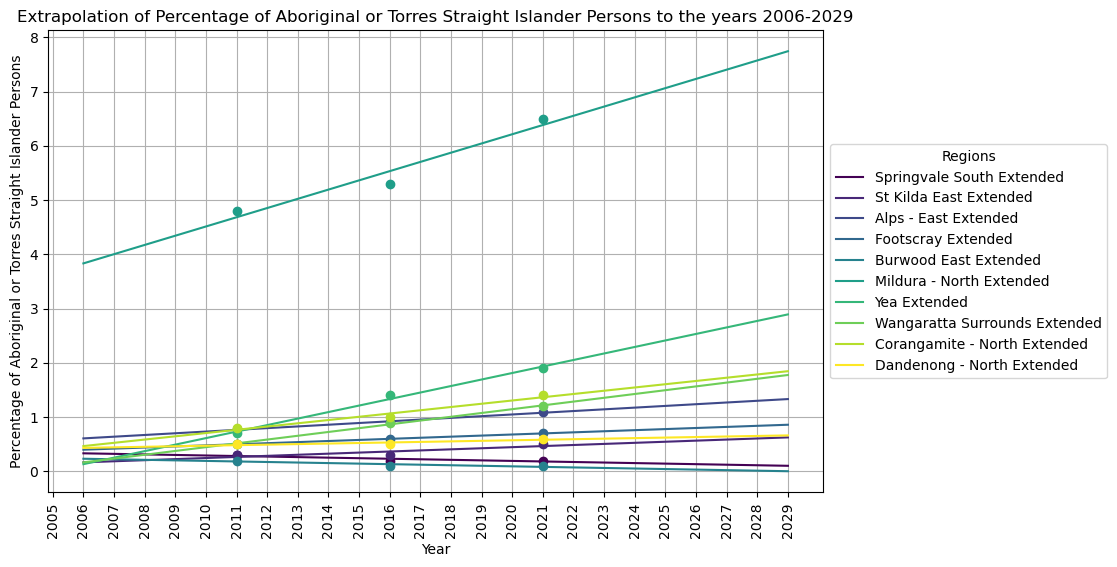

/Users/charlieamad/Documents/GitHub/project-2-group-real-estate-industry-project-31/scripts/preproccessing.py:210: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace('-', np.nan, inplace=True) # replace '-' values with NaN
/Users/charlieamad/Documents/GitHub/project-2-group-real-estate-industry-project-31/scripts/preproccessing.py:222: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna(df.mean(), inplace=True)



Rows with NaN values: ['Alps - East', 'Alps - West', 'Essendon Airport', 'Lake King', 'Moorabbin Airport', 'Royal Botanic Gardens Victoria', 'West Melbourne - Industrial', 'Wilsons Promontory']


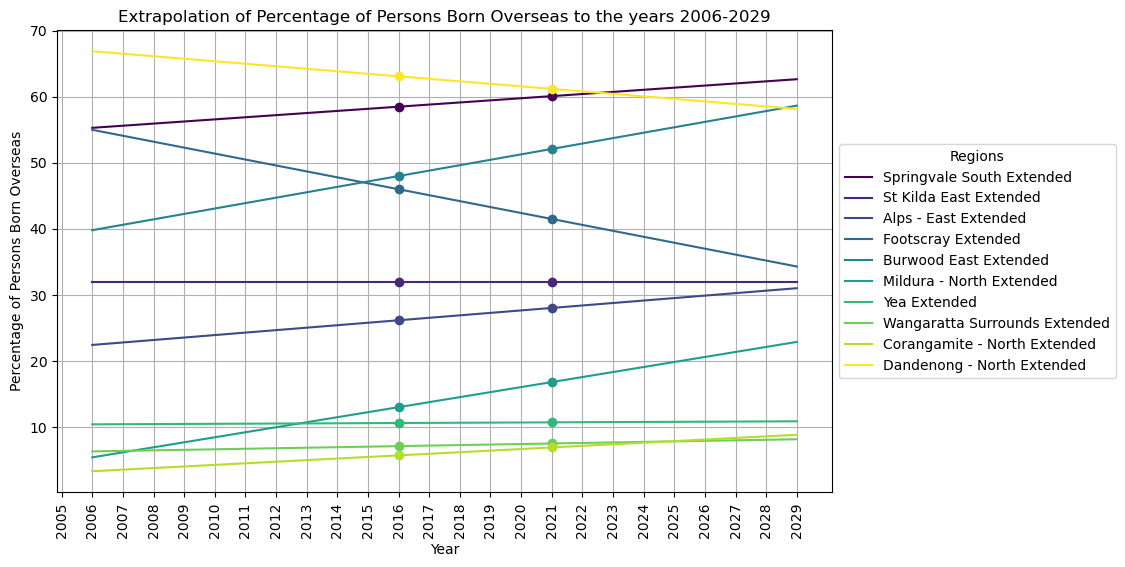

/Users/charlieamad/Documents/GitHub/project-2-group-real-estate-industry-project-31/scripts/preproccessing.py:210: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace('-', np.nan, inplace=True) # replace '-' values with NaN
/Users/charlieamad/Documents/GitHub/project-2-group-real-estate-industry-project-31/scripts/preproccessing.py:222: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna(df.mean(), inplace=True)



Rows with NaN values: ['Alps - East', 'Alps - West', 'Braeside', 'Clyde North - North', 'Essendon Airport', 'Flemington Racecourse', 'French Island', 'Lake King', 'Moorabbin Airport', 'Royal Botanic Gardens Victoria', 'West Melbourne - Industrial', 'Wilsons Promontory']


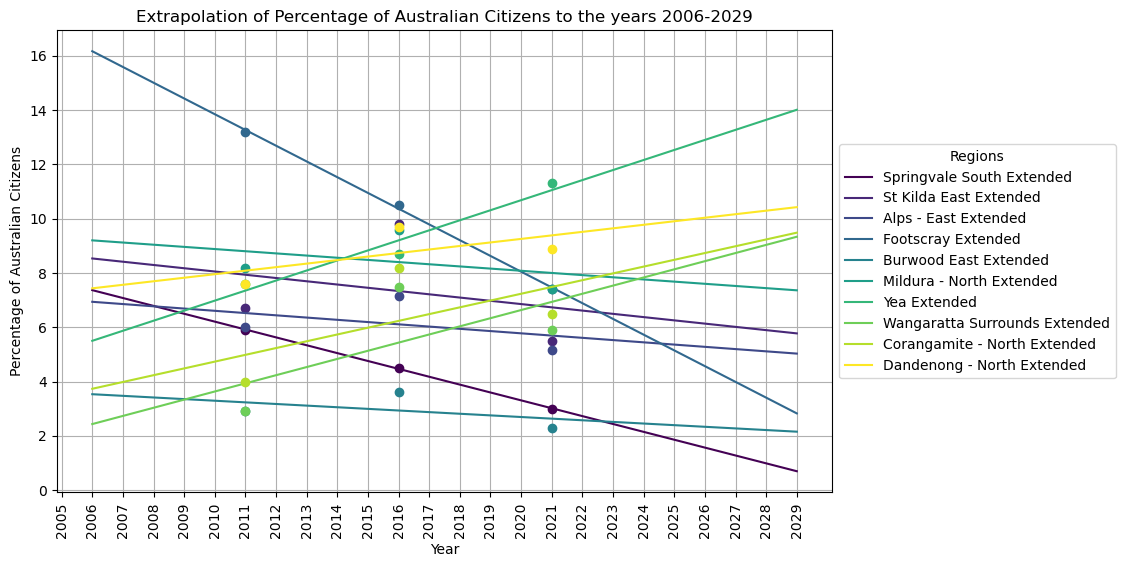

In [70]:
extended_population_density_df = extend_data(population_density_df, 'Population Density in persons/km^2')
extended_median_age_df = extend_data(median_age_df, 'Median Age')
extended_overseas_arrivals_df = extend_data(overseas_arrivals_df, 'Number of Overseas Arrivals')
extended_percentage_aboriginal_torres_straight_df = extend_data(percentage_aboriginal_torres_straight_df, 'Percentage of Aboriginal or Torres Straight Islander Persons')
extended_percentage_overseas_born_df = extend_data(percentage_overseas_born_df, 'Percentage of Persons Born Overseas')
extended_percentage_australian_citizen_df = extend_data(percentage_australian_citizen_df, 'Percentage of Australian Citizens')

In [71]:
# business data

In [72]:
business_df = pd.read_excel('../data/business/business.xlsx', sheet_name='Table 1')

In [73]:
business_df = business_df.loc[9879:14576]
business_df = business_df.iloc[:, [1, 2, 7]]
business_df.columns = ['SA2_name_2021', 'Year', 'Total Number of Businesses']

In [74]:
business_df = business_df.pivot(index='SA2_name_2021', columns='Year', values='Total Number of Businesses')

/Users/charlieamad/Documents/GitHub/project-2-group-real-estate-industry-project-31/scripts/preproccessing.py:210: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace('-', np.nan, inplace=True) # replace '-' values with NaN
/Users/charlieamad/Documents/GitHub/project-2-group-real-estate-industry-project-31/scripts/preproccessing.py:222: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna(df.mean(), inplace=True)



Rows with NaN values: ['Alps - East', 'Lake King', 'Wilsons Promontory']


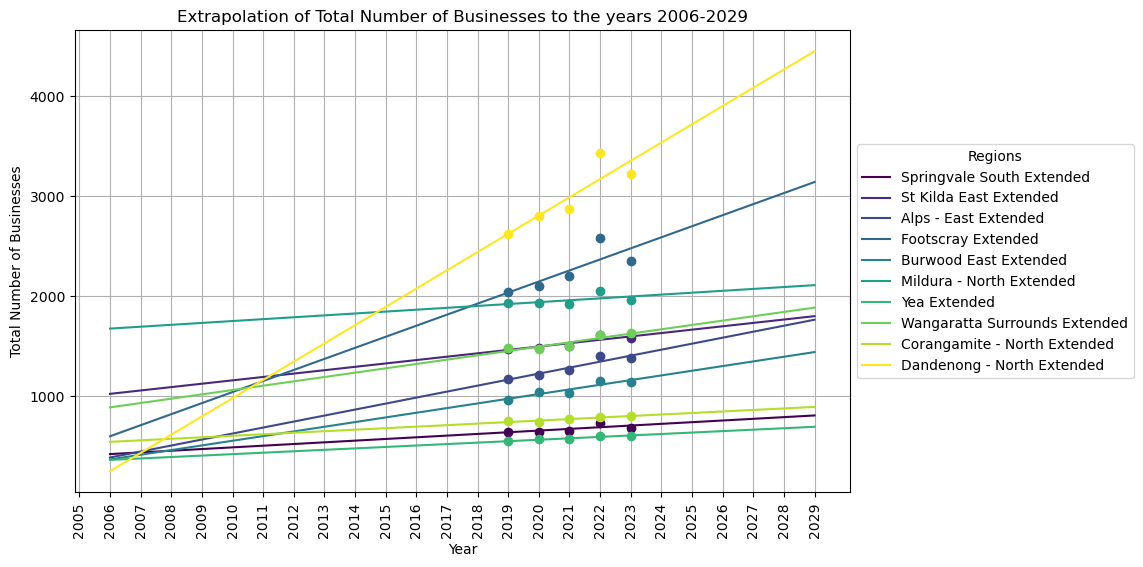

In [75]:
extended_business_df = extend_data(business_df, 'Total Number of Businesses')

In [76]:
# income data

In [77]:
income_df = pd.read_excel('../data/income/income.xlsx', sheet_name='Table 1')

In [78]:
income_df = income_df.loc[8782:12957]
income_df = income_df.iloc[:, [1, 2, 30]]
income_df.columns = ['SA2_name_2021', 'Year', 'Median Total Income']

In [79]:
income_df = income_df.pivot(index='SA2_name_2021', columns='Year', values='Median Total Income')

/Users/charlieamad/Documents/GitHub/project-2-group-real-estate-industry-project-31/scripts/preproccessing.py:210: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace('-', np.nan, inplace=True) # replace '-' values with NaN
/Users/charlieamad/Documents/GitHub/project-2-group-real-estate-industry-project-31/scripts/preproccessing.py:222: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna(df.mean(), inplace=True)



Rows with NaN values: ['Alps - East', 'Avondale Heights', 'Ballarat East - Warrenheip', 'Ballarat North - Invermay', 'Baranduda - Leneva', 'Barwon Heads - Armstrong Creek', 'Beaconsfield - Officer', 'Berwick - South East', 'Berwick - South West', 'Brookfield', 'Brunswick - North', 'Brunswick - South', 'Bunyip - Garfield', 'Canadian - Mount Clear', 'Charlemont', 'Clayton (North) - Notting Hill', 'Clayton - Central', 'Clyde North - North', 'Clyde North - South', 'Cobblebank - Strathtulloh', 'Coburg - East', 'Coburg - West', 'Corio - Lovely Banks', 'Craigieburn - North West', 'Craigieburn - West', 'Cranbourne East - North', 'Cranbourne East - South', 'Cranbourne North - East', 'Cranbourne North - West', 'Dandenong - North', 'Dandenong - South', 'Deer Park', 'Derrimut', 'Diggers Rest', 'Doreen - North', 'Doreen - South', 'Essendon (West) - Aberfeldie', 'Essendon - East', 'Essendon Airport', 'Eynesbury - Exford', 'Fraser Rise - Plumpton', 'Glenroy - East', 'Glenroy - West', 'Grovedale - Mo

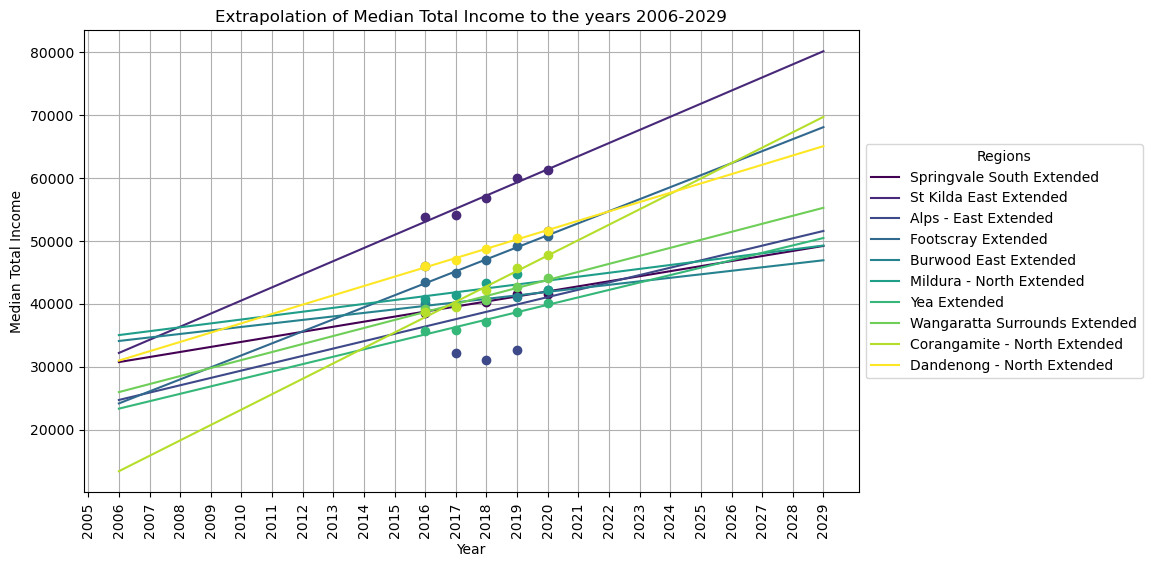

In [80]:
extended_income_df = extend_data(income_df, 'Median Total Income')

In [81]:
# unemployment data

In [82]:
unemployment_df = pd.read_excel('../data/unemployment/unemployment.xlsx', sheet_name='Table 1')

In [83]:
unemployment_df = unemployment_df.loc[8782:12957]
unemployment_df = unemployment_df.iloc[:, [1, 2, 77]]
unemployment_df.columns = ['SA2_name_2021', 'Year', 'Unemployment Rate']

In [84]:
unemployment_df = unemployment_df.pivot(index='SA2_name_2021', columns='Year', values='Unemployment Rate')

/Users/charlieamad/Documents/GitHub/project-2-group-real-estate-industry-project-31/scripts/preproccessing.py:210: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace('-', np.nan, inplace=True) # replace '-' values with NaN
/Users/charlieamad/Documents/GitHub/project-2-group-real-estate-industry-project-31/scripts/preproccessing.py:222: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna(df.mean(), inplace=True)



Rows with NaN values: ['Alps - East', 'Alps - West', 'Braeside', 'Clyde North - North', 'Essendon Airport', 'Flemington Racecourse', 'French Island', 'Lake King', 'Melbourne Airport', 'Moorabbin Airport', 'Royal Botanic Gardens Victoria', 'Truganina - North', 'West Melbourne - Industrial', 'Wilsons Promontory']


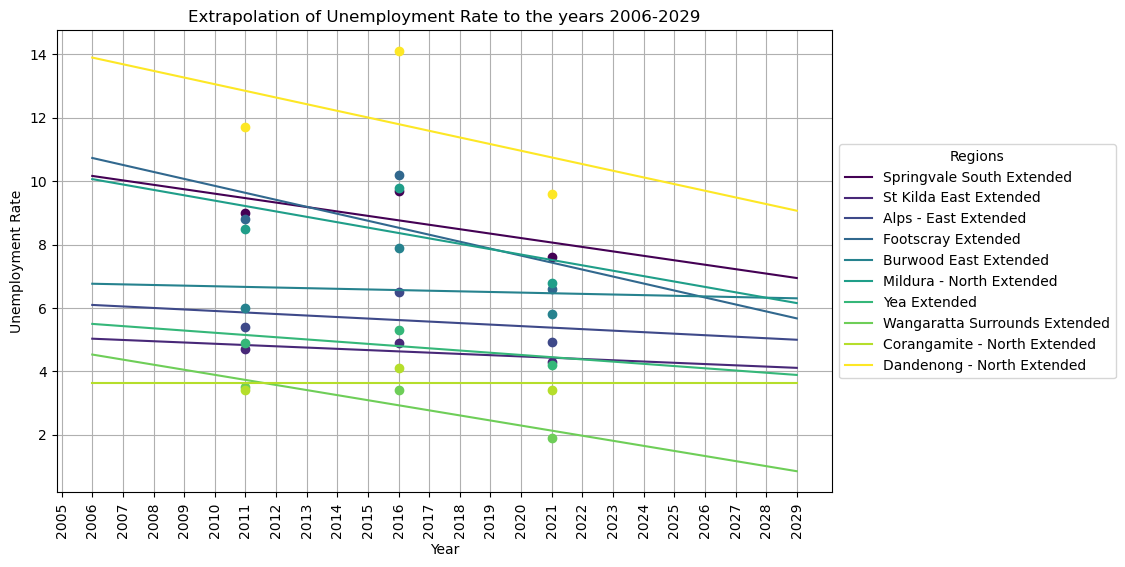

In [85]:
extended_unemployment_df = extend_data(unemployment_df, 'Unemployment Rate')

In [86]:
# community data

In [87]:
community_df = pd.read_excel('../data/community/community.xlsx', sheet_name='Table 1')

In [88]:
community_df = community_df.loc[8782:12957]
community_df = community_df.iloc[:, [1, 2, 29, 49, 75]]
community_df.columns = ['SA2_name_2021', 'Year', 'Average Household Size', 'Median Weekly Rent', 'Percentage Rental Properties']

In [89]:
ave_household_size_df = community_df.pivot(index='SA2_name_2021', columns='Year', values='Average Household Size')
median_rent_df = community_df.pivot(index='SA2_name_2021', columns='Year', values='Median Weekly Rent')
percentage_rentals_df = community_df.pivot(index='SA2_name_2021', columns='Year', values='Percentage Rental Properties')

/Users/charlieamad/Documents/GitHub/project-2-group-real-estate-industry-project-31/scripts/preproccessing.py:210: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace('-', np.nan, inplace=True) # replace '-' values with NaN
/Users/charlieamad/Documents/GitHub/project-2-group-real-estate-industry-project-31/scripts/preproccessing.py:222: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna(df.mean(), inplace=True)



Rows with NaN values: ['Alps - East', 'Essendon Airport', 'Lake King', 'Moorabbin Airport', 'West Melbourne - Industrial']


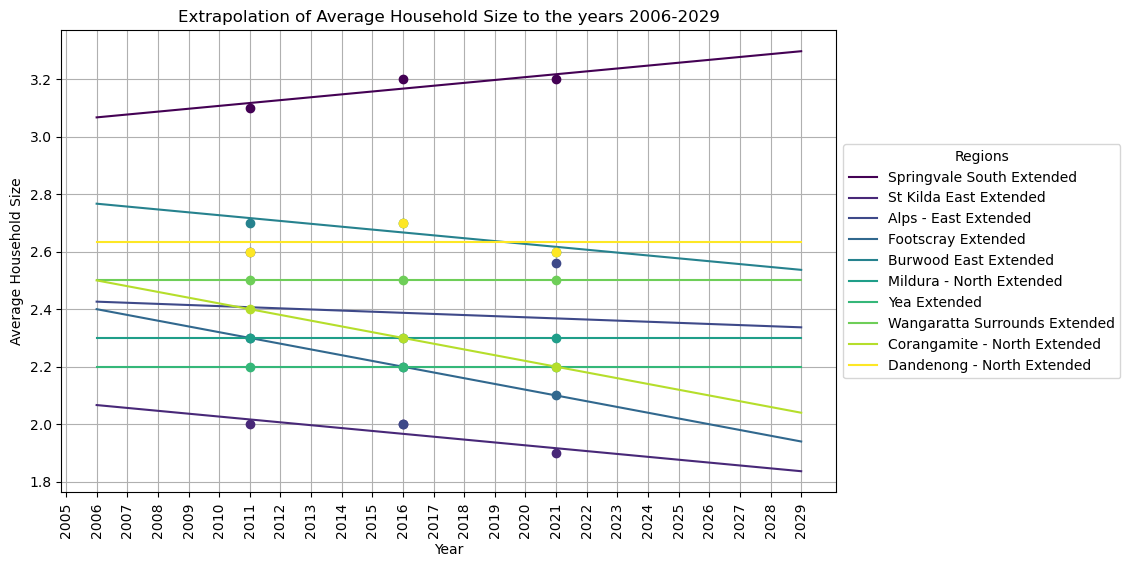

/Users/charlieamad/Documents/GitHub/project-2-group-real-estate-industry-project-31/scripts/preproccessing.py:210: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace('-', np.nan, inplace=True) # replace '-' values with NaN
/Users/charlieamad/Documents/GitHub/project-2-group-real-estate-industry-project-31/scripts/preproccessing.py:222: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna(df.mean(), inplace=True)



Rows with NaN values: ['Alps - East', 'Essendon Airport', 'Lake King', 'Moorabbin Airport', 'Royal Botanic Gardens Victoria', 'West Melbourne - Industrial']


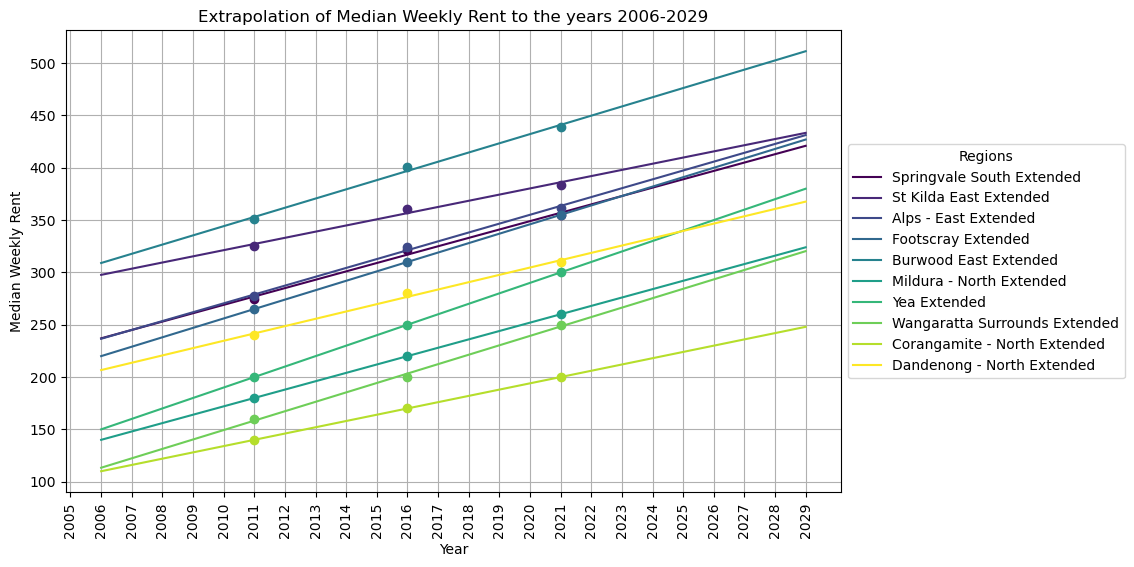

/Users/charlieamad/Documents/GitHub/project-2-group-real-estate-industry-project-31/scripts/preproccessing.py:210: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace('-', np.nan, inplace=True) # replace '-' values with NaN
/Users/charlieamad/Documents/GitHub/project-2-group-real-estate-industry-project-31/scripts/preproccessing.py:222: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna(df.mean(), inplace=True)



Rows with NaN values: ['Alps - East', 'Alps - West', 'Braeside', 'Clyde North - North', 'Essendon Airport', 'French Island', 'Lake King', 'Melbourne Airport', 'Moorabbin Airport', 'Royal Botanic Gardens Victoria', 'Tarneit - North', 'Truganina - North', 'West Melbourne - Industrial']


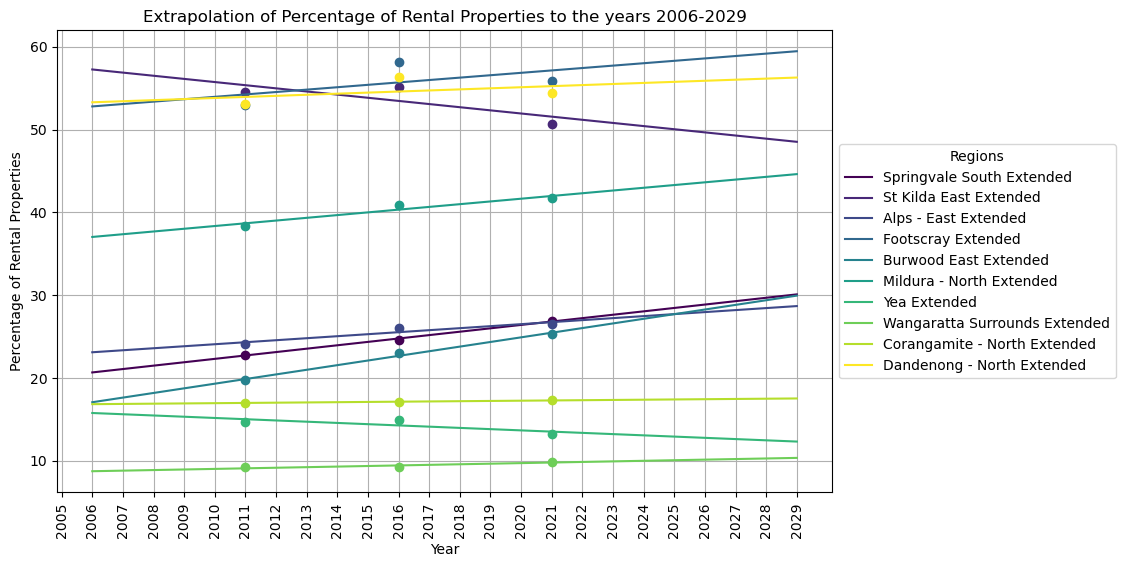

In [90]:
extended_ave_household_size_df = extend_data(ave_household_size_df, 'Average Household Size')
extended_median_rent_df = extend_data(median_rent_df, 'Median Weekly Rent')
extended_percentage_rentals_df = extend_data(percentage_rentals_df, 'Percentage of Rental Properties')